['Physics', 'Social Science', 'Psychology', 'Animal Science', 'Medicine', 'Chemistry', 'Epidemiology', 'Biology', 'Health', 'Anthropology', 'Environment', 'Astronomy', 'Neuroscience', 'Engineering', 'Cancer', 'Nanoscience', 'Computer Science', 'Economics', 'Paleontology', 'Geology', 'Earth Science', 'Space', 'Social Sciences']
Enter topic from list:Environment
Enter title of post: asdhfaksjdhflaksjdf halks jdfhaksdj fhlaksjdh flkajsdh flakjsd hflaksjdhf alkjsdh falksjd hfalkjsdh flakjsd hfalksjd fhalkjsd fhalksjdf halksjdfhalskjdf halskjdh f


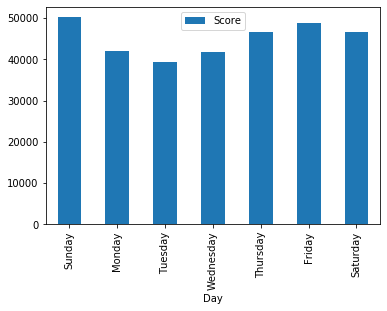

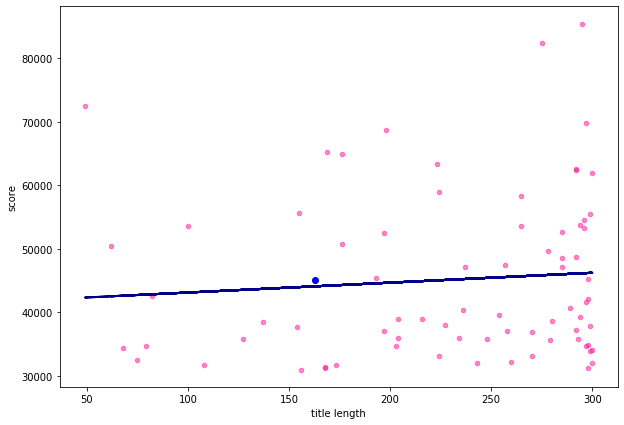

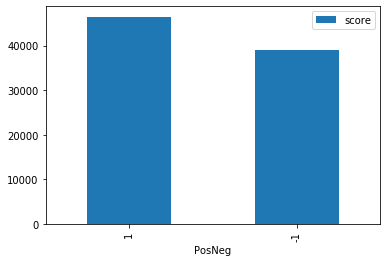

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

#read in .csv file generated from reddit scrape
rsci_posts = pd.read_csv('top1krsciposts.csv')

rsci_posts.sort_values(by='score')

#nltk implementation
sia = SIA()

#iterates through posts, assigning a positive (1) or negative (-1) label to each post, and adding that column to the dataframe
source:https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
results = []
for titles in rsci_posts['title']:
    pol_score = sia.polarity_scores(titles)
    pol_score['title'] = titles
    results.append(pol_score)

table = pd.DataFrame.from_records(results)

table['label'] = 0
table.loc[table['compound'] > 0.4, 'label'] = 1
table.loc[table['compound'] < -0.4, 'label'] = -1

labels = []
for label in table['label']:
    labels.append(label)

rsci_posts['PosNeg'] = labels

#measures title length of each post, adds that integer into a column of the dataframe
tlength = []
for title in rsci_posts['title']:
    titlen = len(title)
    tlength.append(titlen)
rsci_posts['title length'] = tlength

#converts utc time of each post into human-readable weekday column
utc_times = []
for utc in rsci_posts['post time']:
    new_time = time.strftime('%A', time.gmtime(utc))
    utc_times.append(new_time)
rsci_posts['Day of week'] = utc_times


# acquire all unique topic tags
unique_flair = rsci_posts['flair'].unique()

# remove noise data (outliers, non-topic flair)
unique_flair = unique_flair.tolist()
noise_flair = ['Breaking News', 'Subreddit Discussion', 'Medicine - Misleading', 'Subreddit News', 'NASA News',
               'Psychology - Author in Comments', 'Artificial Intelligence AMA']
for i in noise_flair:
    unique_flair.remove(i)

# create list of average score data by topic flair
score_by_flair = []
for i in unique_flair:
    avg_score_by_flair = (rsci_posts[rsci_posts['flair'] == i]['score']).mean(axis=0)
    score_by_flair.append(avg_score_by_flair)

# change list to DataFrame comprised of both lists
score_and_flair = pd.DataFrame(
    {'Flair': unique_flair,
     'Score': score_by_flair
     })
#accepts user input of topic (from list) and title (propsed text in post name)
#outputs 3 plots
def optimize_post(topic, title):
    #filters out all posts not tagged with user-indicated flair
    topic_posts = rsci_posts[rsci_posts['flair'] == topic]
    
    #generates a DataFrame of average score of post by parent topic
    avg_score_flair = score_and_flair[score_and_flair['Flair'] == topic]['Score']
    
    #creates score by day data for the users chosen topic
    score_by_day = []
    Days_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    for j in Days_week:
        avg_score_by_day = (topic_posts[topic_posts['Day of week'] == j]['score']).mean(axis=0)
        score_by_day.append(avg_score_by_day)
    score_and_day = pd.DataFrame(
        {'Day': Days_week,
         'Score': score_by_day}
    )
    #generates bar chart displaying average score by each day
    score_and_day.plot(kind='bar', x='Day', y='Score')
    
    #generate regression line
    #source:https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c
    topic_fit = np.polyfit(topic_posts['title length'], topic_posts['score'], 1)
    
    #plot title length v score data
    topic_posts.plot(kind='scatter', x='title length', y='score', color='deeppink', alpha=0.5, figsize=(10, 7))

    #plot regression line
    plt.plot(topic_posts['title length'], topic_fit[0] * topic_posts['title length'] + topic_fit[1], color='darkblue',
             linewidth=2)
    #plot single data point representing users entered data onto the regression line to show estimated post performance
    titlelen = len(title)
    plt.plot(titlelen, avg_score_flair, 'bo')
    
    #creates score by positive vs negative sentiment data using nltk package, makes DataFrame for plotting
    #source:https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
    score_by_sentiment = []
    posvneg = [1, -1]
    for i in posvneg:
        avg_score_by_sentiment = topic_posts[topic_posts['PosNeg'] == i]['score'].mean(axis=0)
        score_by_sentiment.append(avg_score_by_sentiment)
    score_and_sentiment = pd.DataFrame({
        'PosNeg':posvneg,
        'score':score_by_sentiment
    })
    #plots sentiment data
    score_and_sentiment.plot(kind='bar',x='PosNeg',y='score')
    plt.show()


#user prompts
print(unique_flair)
user_topic = input('Enter topic from list:')
user_title = input('Enter title of post: ')

#call function
optimize_post(user_topic, user_title)
